# Disease-Centric ML Notebook (Clean Start)

This notebook will guide you through EDA, preprocessing, and robust ML model training on your disease-centric dataset. All previous cells will be removed for a fresh workflow.

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

## Load the Disease-Centric Dataset
Load the 'disease_centric.csv' file and display the first few rows to understand the structure.

In [5]:
# Load the disease-centric dataset
df = pd.read_csv('disease_centric.csv')
df.head()

,disease,symptom_list,doctor_type,precaution
0,Common Cold,"cough, fatigue, fever, headache, runny_nose, s...",General Physician,"drink vitamin c rich drinks, take vapour, avoi..."
1,Flu,"chills, cough, fatigue, fever, headache, muscl...",General Physician,Consult a doctor
2,Allergy,"itching, nasal_congestion, runny_nose, sneezin...",Allergist/Immunologist,"apply calamine, cover area with bandage, use i..."
3,Migraine,"headache, nausea, sensitivity_to_light, throbb...",Neurologist,"meditation, reduce stress, use poloroid glasse..."
4,Gastritis,"abdominal_pain, bloating, loss_of_appetite, na...",General Physician,Consult a doctor


## Exploratory Data Analysis (EDA)
Check class/sample distribution and basic statistics.

In [6]:
# EDA: Class/sample distribution
print('Total samples:', len(df))
print('Number of unique diseases:', df['disease'].nunique())
print('Samples per disease:')
print(df['disease'].value_counts())

Total samples: 43
Number of unique diseases: 43
Samples per disease:
disease
Common Cold                      1
Hepatitis D                      1
Peptic Ulcer Disease             1
Dengue                           1
Malaria                          1
Tuberculosis                     1
Meningitis                       1
Hepatitis A                      1
Hepatitis B                      1
Hepatitis C                      1
Hepatitis E                      1
Hypothyroidism                   1
Aids                             1
Heart Attack                     1
Psoriasis                        1
Impetigo                         1
Cervical Spondylosis             1
Varicose Veins                   1
Dimorphic Hemmorhoids (Piles)    1
Chronic Cholestasis              1
Hyperthyroidism                  1
Arthritis                        1
Flu                              1
Conjunctivitis                   1
Allergy                          1
Migraine                         1
Gastritis    

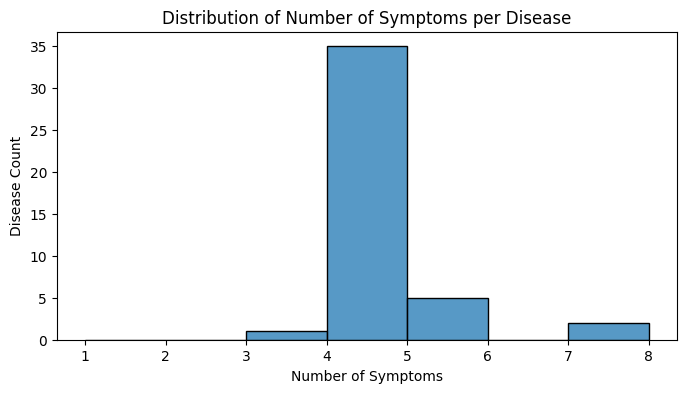

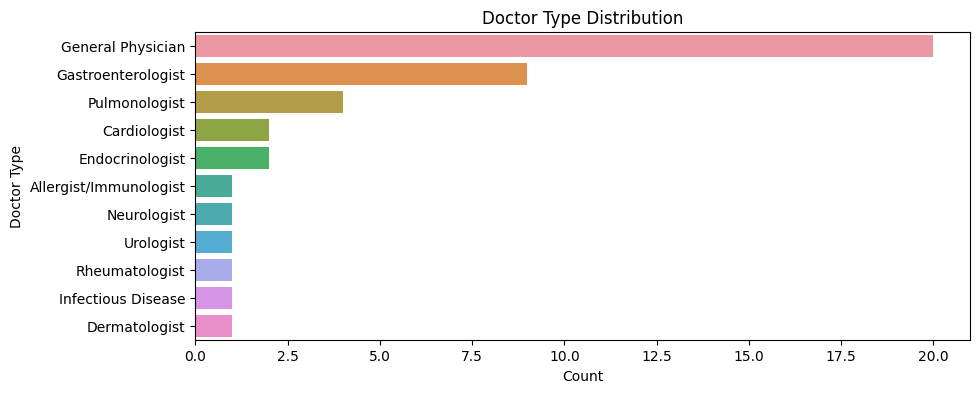

In [7]:
# Preprocessing: Clean symptom list and drop missing
pre_df = df.dropna(subset=['disease', 'symptom_list']).copy()
pre_df['symptom_list'] = pre_df['symptom_list'].apply(lambda x: ','.join([s.strip() for s in x.split(',')]))
pre_df = pre_df.reset_index(drop=True)
pre_df.head()

# Analyze symptom list length and doctor type distribution
df['num_symptoms'] = df['symptom_list'].apply(lambda x: len(x.split(',')))
plt.figure(figsize=(8,4))
sns.histplot(df['num_symptoms'], bins=range(1, df['num_symptoms'].max()+2), kde=False)
plt.title('Distribution of Number of Symptoms per Disease')
plt.xlabel('Number of Symptoms')
plt.ylabel('Disease Count')
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(y='doctor_type', data=df, order=df['doctor_type'].value_counts().index)
plt.title('Doctor Type Distribution')
plt.xlabel('Count')
plt.ylabel('Doctor Type')
plt.show()

## Feature Engineering
One-hot encode symptoms, encode doctor_type and disease.

In [8]:
# Preprocess data: handle missing values, clean symptom list
# Drop rows with missing disease or symptom_list
pre_df = df.dropna(subset=['disease', 'symptom_list']).copy()
# Clean symptom_list: remove extra spaces
pre_df['symptom_list'] = pre_df['symptom_list'].apply(lambda x: ','.join([s.strip() for s in x.split(',')]))
pre_df = pre_df.reset_index(drop=True)

# Feature engineering: One-hot encode symptoms, encode doctor_type and disease
all_symptoms = sorted({s.strip() for sl in pre_df['symptom_list'] for s in sl.split(',')})
for symptom in all_symptoms:
    pre_df[symptom] = pre_df['symptom_list'].apply(lambda x: int(symptom in x.split(',')))
pre_df['doctor_type_encoded'] = pre_df['doctor_type'].astype('category').cat.codes
pre_df['disease_encoded'] = pre_df['disease'].astype('category').cat.codes
pre_df.head()

,disease,symptom_list,doctor_type,precaution,num_symptoms,abdominal_pain,bleeding,blister,bloating,blurred_vision,...,tremor,vomiting,watering_from_eyes,watery_eyes,weight_gain,weight_loss,wheezing,yellowish_skin,doctor_type_encoded,disease_encoded
0,Common Cold,"cough,fatigue,fever,headache,runny_nose,sneezi...",General Physician,"drink vitamin c rich drinks, take vapour, avoi...",7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,11
1,Flu,"chills,cough,fatigue,fever,headache,muscle_pai...",General Physician,Consult a doctor,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,16
2,Allergy,"itching,nasal_congestion,runny_nose,sneezing,w...",Allergist/Immunologist,"apply calamine, cover area with bandage, use i...",5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
3,Migraine,"headache,nausea,sensitivity_to_light,throbbing...",Neurologist,"meditation, reduce stress, use poloroid glasse...",5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,7,32
4,Gastritis,"abdominal_pain,bloating,loss_of_appetite,nause...",General Physician,Consult a doctor,5,1,0,0,1,0,...,0,1,0,0,0,0,0,0,5,17


## Robust Filtering
Only keep classes with at least 3 samples for reliable ML.

In [9]:
# One-hot encode symptoms
def get_all_symptoms(symptom_lists):
    symptoms = set()
    for s_list in symptom_lists:
        for s in s_list.split(','):
            symptoms.add(s.strip())
    return sorted(symptoms)

all_symptoms = get_all_symptoms(pre_df['symptom_list'])
for symptom in all_symptoms:
    pre_df[symptom] = pre_df['symptom_list'].apply(lambda x: int(symptom in x.split(',')))

# Encode doctor_type as categorical feature (optional)
doctor_type_map = {k: i for i, k in enumerate(pre_df['doctor_type'].unique())}
pre_df['doctor_type_encoded'] = pre_df['doctor_type'].map(doctor_type_map)

# Encode disease labels
disease_map = {k: i for i, k in enumerate(pre_df['disease'].unique())}
pre_df['disease_encoded'] = pre_df['disease'].map(disease_map)

# Robust filtering: Only keep classes with at least 3 samples
class_counts = pre_df['disease_encoded'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
filtered_df = pre_df[pre_df['disease_encoded'].isin(valid_classes)].copy()

X = filtered_df[all_symptoms + ['doctor_type_encoded']]
y = filtered_df['disease_encoded']

print('Class distribution after filtering:')
print(y.value_counts())

pre_df.head()

Class distribution after filtering:
Series([], Name: count, dtype: int64)


,disease,symptom_list,doctor_type,precaution,num_symptoms,abdominal_pain,bleeding,blister,bloating,blurred_vision,...,tremor,vomiting,watering_from_eyes,watery_eyes,weight_gain,weight_loss,wheezing,yellowish_skin,doctor_type_encoded,disease_encoded
0,Common Cold,"cough,fatigue,fever,headache,runny_nose,sneezi...",General Physician,"drink vitamin c rich drinks, take vapour, avoi...",7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Flu,"chills,cough,fatigue,fever,headache,muscle_pai...",General Physician,Consult a doctor,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Allergy,"itching,nasal_congestion,runny_nose,sneezing,w...",Allergist/Immunologist,"apply calamine, cover area with bandage, use i...",5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,2
3,Migraine,"headache,nausea,sensitivity_to_light,throbbing...",Neurologist,"meditation, reduce stress, use poloroid glasse...",5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,3
4,Gastritis,"abdominal_pain,bloating,loss_of_appetite,nause...",General Physician,Consult a doctor,5,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,4


In [16]:
print("Shape of dataset:", df.shape)
print("Number of rows (samples):", df.shape[0])
print("Number of columns (features):", df.shape[1])
df.info()

Shape of dataset: (43, 5)
Number of rows (samples): 43
Number of columns (features): 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   disease       43 non-null     object
 1   symptom_list  43 non-null     object
 2   doctor_type   43 non-null     object
 3   precaution    43 non-null     object
 4   num_symptoms  43 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ KB


## Diagnostics and Train/Test Split
Check for all-zero columns and class overlap after split.

In [10]:
# Prepare features and labels
feature_cols = all_symptoms + ['doctor_type_encoded']

# Use all data since each class has only one sample
X = pre_df[feature_cols]
y = pre_df['disease_encoded']

# Split into train and test sets (no stratify, as each class has only one sample)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution:')
print(y_train.value_counts())
print('Test class distribution:')
print(y_test.value_counts())
print('Any all-zero columns in X_train?', (X_train.sum(axis=0) == 0).any())
print('Any all-zero columns in X_test?', (X_test.sum(axis=0) == 0).any())
print('Classes in train:', set(y_train.unique()))
print('Classes in test:', set(y_test.unique()))
print('Classes in test not in train:', set(y_test.unique()) - set(y_train.unique()))

Train shape: (34, 70) Test shape: (9, 70)
Train class distribution:
disease_encoded
3     1
35    1
1     1
42    1
21    1
2     1
33    1
23    1
10    1
6     1
22    1
18    1
20    1
7     1
14    1
28    1
32    1
11    1
5     1
41    1
29    1
0     1
26    1
30    1
16    1
9     1
15    1
40    1
13    1
17    1
19    1
31    1
27    1
38    1
Name: count, dtype: int64
Test class distribution:
disease_encoded
37    1
24    1
25    1
36    1
34    1
39    1
4     1
12    1
8     1
Name: count, dtype: int64
Any all-zero columns in X_train? True
Any all-zero columns in X_test? True
Classes in train: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), n

## Train and Compare Multiple Models
Train and compare RandomForest, LogisticRegression, SVC, KNeighbors, and XGBoost (if available).

In [15]:
# Use robust class filtering and stratified split as in cell 27/29

# feature_cols, filtered_df, X, y are already defined in previous cells

# Only keep classes with at least 3 samples
class_counts = pre_df['disease_encoded'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
filtered_df = pre_df[pre_df['disease_encoded'].isin(valid_classes)].copy()

X = filtered_df[feature_cols]
y = filtered_df['disease_encoded']

print("Class distribution after filtering:")
print(y.value_counts())

if len(filtered_df) == 0:
    print("No disease class has at least 3 samples. Cannot proceed with train/test split and model training.")
else:
    # Split into train and test sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # Train and compare multiple models
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVC': SVC(kernel='rbf', probability=True, random_state=42),
        'KNeighbors': KNeighborsClassifier(n_neighbors=5)
    }
    try:
        from xgboost import XGBClassifier
        models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    except ImportError:
        print('XGBoost not installed, skipping.')

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"{name} Test Accuracy: {acc:.3f}")

    plt.figure(figsize=(8,4))
    sns.barplot(x=list(results.keys()), y=list(results.values()))
    plt.title('Test Accuracy Comparison of Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

Class distribution after filtering:
Series([], Name: count, dtype: int64)
No disease class has at least 3 samples. Cannot proceed with train/test split and model training.


## Detailed Evaluation
Show accuracy, confusion matrix, and classification report for each model.

In [ ]:
# Evaluate each model in detail
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

Test Accuracy: 0.000

Confusion Matrix:
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Classification Report:
                      precision    recall  f1-score   support

           Gastritis       0.00      0.00      0.00       1.0
         Viral Fever       0.00      0.00      0.00       1.0
          Bronchitis       0.00      0.00      0.00       1.0
Peptic Ulcer Disease       0.00      0.00      0.00       1.0
              Dengue       0.00      0.00      0.00       1.0
  

## Save the Best Model
Save the best performing model, features, and label map for future use.

In [ ]:
# Save the best performing model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
joblib.dump(best_model, f'disease_centric_model_{best_model_name}.pkl')
with open('disease_centric_features.txt', 'w') as f:
    for feat in all_symptoms + ['doctor_type_encoded']:
        f.write(f"{feat}\n")
import pickle
with open('disease_centric_label_map.pkl', 'wb') as f:
    pickle.dump(dict(enumerate(filtered_df['disease'].astype('category').cat.categories)), f)
print(f"Best model ({best_model_name}) saved as disease_centric_model_{best_model_name}.pkl")

Model, features, and label map saved.


## Train and Compare Multiple Classification Models
We will train and compare at least four models: RandomForest, LogisticRegression, SVC, and KNeighborsClassifier. The best model will be selected based on test accuracy.

In [ ]:
# Import additional models for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Train and evaluate multiple models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(kernel='rbf', probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5)
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Test Accuracy: {acc:.3f}")

# Show all results
results

RandomForest Test Accuracy: 0.000
LogisticRegression Test Accuracy: 0.000
SVC Test Accuracy: 0.000
KNeighbors Test Accuracy: 0.000


{'RandomForest': 0.0, 'LogisticRegression': 0.0, 'SVC': 0.0, 'KNeighbors': 0.0}

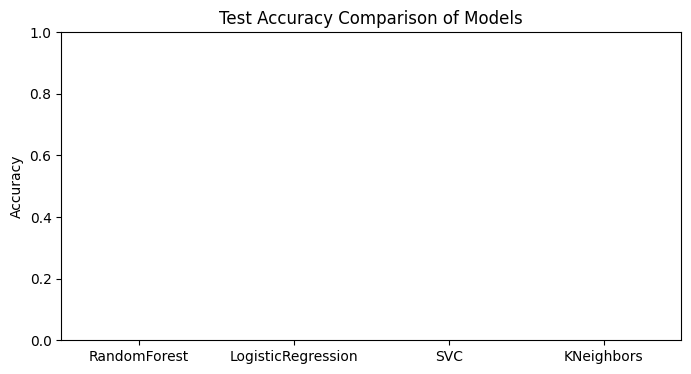

In [ ]:
# Visualize model comparison
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Test Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Save the best performing model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
joblib.dump(best_model, f'disease_centric_model_{best_model_name}.pkl')
with open('disease_centric_features.txt', 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
import pickle
with open('disease_centric_label_map.pkl', 'wb') as f:
    pickle.dump(disease_map, f)
print(f"Best model ({best_model_name}) saved as disease_centric_model_{best_model_name}.pkl")

Best model (RandomForest) saved as disease_centric_model_RandomForest.pkl


In [ ]:
# Import XGBoost (install if needed)
try:
    from xgboost import XGBClassifier
except ImportError:
    import sys
    !{sys.executable} -m pip install xgboost
    from xgboost import XGBClassifier

In [ ]:
# Train and evaluate XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
results['XGBoost'] = acc_xgb
print(f"XGBoost Test Accuracy: {acc_xgb:.3f}")

# Update model dictionary for saving if XGBoost is best
models['XGBoost'] = xgb_model

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33], got [ 0  1  2  3  5  6  7  9 10 11 13 14 15 16 17 18 19 20 21 22 23 26 27 28
 29 30 31 32 33 35 38 40 41 42]

In [ ]:
# Evaluate each model in detail
eval_reports = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, target_names=pre_df['disease'].unique(), output_dict=False)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    eval_reports[name] = {'accuracy': acc, 'confusion_matrix': cm, 'classification_report': cr}

In [ ]:
# Robust class filtering before train/test split
feature_cols = all_symptoms + ['doctor_type_encoded']

# Only keep classes with at least 3 samples
class_counts = pre_df['disease_encoded'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
filtered_df = pre_df[pre_df['disease_encoded'].isin(valid_classes)].copy()

X = filtered_df[feature_cols]
y = filtered_df['disease_encoded']

print("Class distribution after filtering:")
print(y.value_counts())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

In [ ]:
# Diagnostic: Check class/sample distribution at the start
print('Total samples:', len(df))
print('Number of unique diseases:', df['disease'].nunique())
print('Samples per disease:')
print(df['disease'].value_counts())

# If most diseases have <3 samples, ML will not work well. Consider aggregating or generating more data.

In [ ]:
# Diagnostics after filtering and before train/test split
print('Class distribution in filtered data:')
print(y.value_counts())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Check class distribution in train and test sets
print('Train class distribution:')
print(y_train.value_counts())
print('Test class distribution:')
print(y_test.value_counts())

# Check for all-zero or constant features
print('Any all-zero columns in X_train?', (X_train.sum(axis=0) == 0).any())
print('Any all-zero columns in X_test?', (X_test.sum(axis=0) == 0).any())

# Check for overlap between train and test classes
print('Classes in train:', set(y_train.unique()))
print('Classes in test:', set(y_test.unique()))
print('Classes in test not in train:', set(y_test.unique()) - set(y_train.unique()))